In [1]:
%matplotlib inline


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from tqdm.auto import tqdm

from loren_frank_data_processing import (make_epochs_dataframe, make_neuron_dataframe)
from src.parameters import (ANIMALS, MIN_N_NEURONS, _BRAIN_AREAS)
from ZilongCode.utils import get_sweep_and_awake_replay_results_using_postive_negative_peak_in_LFP

In [3]:
epoch_info = make_epochs_dataframe(ANIMALS)
neuron_info = make_neuron_dataframe(ANIMALS)

neuron_info = neuron_info.loc[
(neuron_info.type == 'principal') &
(neuron_info.numspikes > 100) &
neuron_info.area.isin(_BRAIN_AREAS)]


n_neurons = (neuron_info
                .groupby(['animal', 'day', 'epoch'])
                .neuron_id
                .agg(len)
                .rename('n_neurons')
                .to_frame())

epoch_info = epoch_info.join(n_neurons)
is_w_track = (epoch_info.environment
                .isin(['TrackA', 'TrackB', 'WTrackA', 'WTrackB']))

180.4300774105589

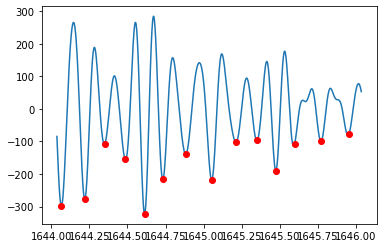

In [4]:
#test the load of LFP info
import os
import pandas as pd
import pickle
import xarray as xr
from ZilongCode.utils import bandpassfilter,get_zero_phase
epoch_key = ('bon', 8, 2)
animal, day, epoch = epoch_key
datadir = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/"
cv_classifier_clusterless_results = xr.open_dataset(os.path.join(datadir, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc'))
with open(os.path.join(datadir, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_speed_info.pkl'), 'rb') as f:
    speed_dic = pickle.load(f)
with open(os.path.join(datadir, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_lfp_info.pkl'), 'rb') as f:
    lfp = pickle.load(f)

lfp = (
    lfp.reset_index(drop=True).set_index(lfp.index / np.timedelta64(1, "s"))
)

# add band passs filter to lfp.iloc[:,0], using band between 5-11Hz
lfp0 = bandpassfilter(lfp.iloc[:, 0], lowcut=5, highcut=11, fs=500)
# group the lfp0 into dataframe with time index
lfp0 = pd.DataFrame(lfp0, index=lfp.index)

zero_phase_index = get_zero_phase(lfp0.iloc[0:1000])

plt.plot(lfp0.iloc[0:1000])
#add zero phase to lfp0 as red point
plt.plot(lfp0.index[zero_phase_index], lfp0.iloc[zero_phase_index], 'ro')

# cv_classifier_clusterless_results.mental_distance_from_actual_position.shape

data_ = cv_classifier_clusterless_results.mental_distance_from_actual_position_ahead_behind.data
np.max(data_)

### 1, get correlation between theta sweep length and the awake replay diffusion exponent

In [4]:
animal_names = ['bon', 'fra', 'gov', 'dud', 'con', 'dav', 'Cor', 'egy', 'cha']

all_sweep_len_peranimal = {}; all_sweep_len_perday = {}
all_sweep_amp_peranimal = {}; all_sweep_amp_perday = {}
all_sweep_ahead_peranimal = {}; all_sweep_ahead_perday = {}
all_sweep_behind_peranimal = {}; all_sweep_behind_perday = {}
all_sweep_mass_peranimal = {}; all_sweep_mass_perday = {}
all_exponent_peranimal = {}; all_exponent_perday = {}
all_intercept_peranimal = {}; all_intercept_perday = {}
all_ave_speed_peranimal = {}; all_ave_speed_perday = {}
all_ave_activespeed_peranimal = {}; all_ave_activespeed_perday = {}
all_behav_exponent_peranimal = {}; all_behav_exponent_perday = {}
DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

for name in animal_names:
    
    is_animal = epoch_info.index.isin([name], level='animal')

    valid_epochs = (is_w_track &
                    (epoch_info.n_neurons > MIN_N_NEURONS) &
                    is_animal
                    )
    
    sweep_len = []
    sweep_amp = []
    sweep_ahead = []
    sweep_behind = []
    sweep_mass = []
    exponent = []
    intercept = []
    ave_speed = []
    ave_activespeed = []
    behav_exponent = []
    for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
        animal, day, epoch = epoch_key
        
        #skip 'egy', 10, 2 since no mental_distance_from_actual_position is saved (double check later)
        if (animal, day, epoch) == ('egy', 10, 2):
            continue
        
        if (animal, day, epoch) == ('bon', 4, 2):
            continue

        print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
        
        #get the average sweep length and replay exponent
        results  = get_sweep_and_awake_replay_results_using_postive_negative_peak_in_LFP(epoch_key, DATA_DIR, sweep_speed_threshold=4)
        
        [mean_immobile_speed, 
         mean_active_speed, 
         behav_exp, 
         mean_sweep_dist, 
         mean_sweep_amp, 
         mean_sweep_ahead, 
         mean_sweep_behind, 
         sweep_mass_i,
         replay_exponent, 
         replay_intercept] = results
        
        #print the average sweep length and replay exponent in one line, keep three decimal places
        # print(f'Average sweep length: {mean_sweep_dist:.3f}, Diffusion exponent: {replay_exponent:.3f}')
        print(f'Sweep length: {mean_sweep_dist:.3f}, \
              Sweep amp: {mean_sweep_amp:.3f}, \
              Sweep ahead: {mean_sweep_ahead},\
              Sweep behind: {mean_sweep_behind},\
              Sweep mass: {sweep_mass_i:.3f},\
              Diffusion exponent: {replay_exponent:.3f}')
        
        #attach (without overwriting) mean_immobile_speed, mean_sweep_dist, replay_exponent to 
        #all_sweep_len_perday, all_exponent_perday, all_ave_speed_perday with the key of (animal, day)
        all_sweep_len_perday.setdefault((animal, day), []).append(mean_sweep_dist)
        all_sweep_amp_perday.setdefault((animal, day), []).append(mean_sweep_amp)
        all_sweep_ahead_perday.setdefault((animal, day), []).append(mean_sweep_ahead)
        all_sweep_behind_perday.setdefault((animal, day), []).append(mean_sweep_behind)
        all_sweep_mass_perday.setdefault((animal, day), []).append(sweep_mass_i)
        all_exponent_perday.setdefault((animal, day), []).append(replay_exponent)
        all_intercept_perday.setdefault((animal, day), []).append(replay_intercept)
        all_ave_speed_perday.setdefault((animal, day), []).append(mean_immobile_speed)
        all_ave_activespeed_perday.setdefault((animal, day), []).append(mean_active_speed)
        all_behav_exponent_perday.setdefault((animal, day), []).append(behav_exp)
        
        ave_speed.append(mean_immobile_speed)
        ave_activespeed.append(mean_active_speed)
        behav_exponent.append(behav_exp)
        sweep_len.append(mean_sweep_dist)
        sweep_amp.append(mean_sweep_amp)
        sweep_ahead.append(mean_sweep_ahead)
        sweep_behind.append(mean_sweep_behind)
        sweep_mass.append(sweep_mass_i)
        exponent.append(replay_exponent)
        intercept.append(replay_intercept)
        
    all_ave_speed_peranimal[name] = ave_speed   
    all_ave_activespeed_peranimal[name] = ave_activespeed
    all_behav_exponent_peranimal[name] = behav_exponent
    all_sweep_len_peranimal[name] = sweep_len
    all_sweep_amp_peranimal[name] = sweep_amp
    all_sweep_ahead_peranimal[name] = sweep_ahead
    all_sweep_behind_peranimal[name] = sweep_behind
    all_sweep_mass_peranimal[name] = sweep_mass
    all_exponent_peranimal[name] = exponent
    all_intercept_peranimal[name] = intercept


epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Animal: bon, Day: 3, Epoch: 2


epochs:   4%|▍         | 1/24 [00:11<04:18, 11.25s/it]

Sweep length: 28.694,               Sweep amp: 49.932,               Sweep ahead: 10.772131907419803,              Sweep behind: -39.16012928329926,              Sweep mass: -13.151,              Diffusion exponent: 0.836
Animal: bon, Day: 3, Epoch: 4


epochs:   8%|▊         | 2/24 [00:19<03:35,  9.78s/it]

Sweep length: 15.452,               Sweep amp: 34.348,               Sweep ahead: 16.73425544943845,              Sweep behind: -17.613581409647303,              Sweep mass: -0.159,              Diffusion exponent: 0.840
Animal: bon, Day: 3, Epoch: 6


epochs:  12%|█▎        | 3/24 [00:28<03:12,  9.16s/it]

Sweep length: 22.764,               Sweep amp: 43.452,               Sweep ahead: 19.865927049294058,              Sweep behind: -23.58567161166832,              Sweep mass: -1.558,              Diffusion exponent: 0.476
Animal: bon, Day: 4, Epoch: 4


epochs:  21%|██        | 5/24 [00:37<02:06,  6.64s/it]

Sweep length: 17.515,               Sweep amp: 35.363,               Sweep ahead: 15.580431096896582,              Sweep behind: -19.78222645907459,              Sweep mass: -2.117,              Diffusion exponent: 0.759
Animal: bon, Day: 4, Epoch: 6


epochs:  25%|██▌       | 6/24 [00:45<02:05,  6.97s/it]

Sweep length: 26.638,               Sweep amp: 44.658,               Sweep ahead: 12.872540269854065,              Sweep behind: -31.785049187993685,              Sweep mass: -9.067,              Diffusion exponent: 0.643
Animal: bon, Day: 5, Epoch: 2


epochs:  29%|██▉       | 7/24 [00:54<02:08,  7.57s/it]

Sweep length: 15.255,               Sweep amp: 33.390,               Sweep ahead: 16.607174781138152,              Sweep behind: -16.782475361993995,              Sweep mass: 0.219,              Diffusion exponent: 0.751
Animal: bon, Day: 5, Epoch: 4


epochs:  33%|███▎      | 8/24 [01:03<02:07,  7.96s/it]

Sweep length: 14.941,               Sweep amp: 31.837,               Sweep ahead: 14.08841259820185,              Sweep behind: -17.748653583176683,              Sweep mass: -1.692,              Diffusion exponent: 0.756
Animal: bon, Day: 5, Epoch: 6


epochs:  38%|███▊      | 9/24 [01:12<02:05,  8.35s/it]

Sweep length: 24.863,               Sweep amp: 38.404,               Sweep ahead: 10.217953961389394,              Sweep behind: -28.186237979066156,              Sweep mass: -8.940,              Diffusion exponent: 0.616
Animal: bon, Day: 6, Epoch: 2


epochs:  42%|████▏     | 10/24 [01:21<01:58,  8.49s/it]

Sweep length: 18.539,               Sweep amp: 36.235,               Sweep ahead: 13.982930034332266,              Sweep behind: -22.25215625561985,              Sweep mass: -3.482,              Diffusion exponent: 0.748
Animal: bon, Day: 6, Epoch: 4


epochs:  46%|████▌     | 11/24 [01:29<01:49,  8.39s/it]

Sweep length: 15.474,               Sweep amp: 32.402,               Sweep ahead: 14.859471834670282,              Sweep behind: -17.542148667028506,              Sweep mass: -1.005,              Diffusion exponent: 0.661
Animal: bon, Day: 6, Epoch: 6


epochs:  50%|█████     | 12/24 [01:37<01:37,  8.13s/it]

Sweep length: 23.922,               Sweep amp: 42.844,               Sweep ahead: 15.346993923978939,              Sweep behind: -27.496820546512122,              Sweep mass: -6.190,              Diffusion exponent: 0.577
Animal: bon, Day: 7, Epoch: 2


epochs:  54%|█████▍    | 13/24 [01:45<01:30,  8.23s/it]

Sweep length: 16.487,               Sweep amp: 34.842,               Sweep ahead: 12.608270768008687,              Sweep behind: -22.233641281571824,              Sweep mass: -3.960,              Diffusion exponent: 0.710
Animal: bon, Day: 7, Epoch: 4


epochs:  58%|█████▊    | 14/24 [01:53<01:21,  8.17s/it]

Sweep length: 13.139,               Sweep amp: 31.495,               Sweep ahead: 15.482465949765164,              Sweep behind: -16.012934182006166,              Sweep mass: -0.002,              Diffusion exponent: 0.617
Animal: bon, Day: 7, Epoch: 6


epochs:  62%|██████▎   | 15/24 [02:01<01:11,  7.95s/it]

Sweep length: 23.875,               Sweep amp: 39.828,               Sweep ahead: 15.114880462782446,              Sweep behind: -24.713085144436857,              Sweep mass: -5.111,              Diffusion exponent: 0.560
Animal: bon, Day: 8, Epoch: 2


epochs:  67%|██████▋   | 16/24 [02:09<01:03,  7.90s/it]

Sweep length: 14.454,               Sweep amp: 32.679,               Sweep ahead: 14.632758925436795,              Sweep behind: -18.046703523103343,              Sweep mass: -1.206,              Diffusion exponent: 0.795
Animal: bon, Day: 8, Epoch: 4


epochs:  71%|███████   | 17/24 [02:16<00:54,  7.79s/it]

Sweep length: 15.309,               Sweep amp: 34.690,               Sweep ahead: 14.018553117511809,              Sweep behind: -20.671014599887943,              Sweep mass: -2.719,              Diffusion exponent: 0.700
Animal: bon, Day: 8, Epoch: 6


epochs:  75%|███████▌  | 18/24 [02:24<00:46,  7.72s/it]

Sweep length: 16.225,               Sweep amp: 36.783,               Sweep ahead: 14.881854599302352,              Sweep behind: -21.901199589480594,              Sweep mass: -2.593,              Diffusion exponent: 0.587
Animal: bon, Day: 9, Epoch: 2


epochs:  79%|███████▉  | 19/24 [02:31<00:37,  7.58s/it]

Sweep length: 16.699,               Sweep amp: 34.632,               Sweep ahead: 15.403068037066902,              Sweep behind: -19.228830749168207,              Sweep mass: -1.533,              Diffusion exponent: 0.738
Animal: bon, Day: 9, Epoch: 4


epochs:  83%|████████▎ | 20/24 [02:38<00:29,  7.47s/it]

Sweep length: 12.199,               Sweep amp: 28.893,               Sweep ahead: 15.090519648923182,              Sweep behind: -13.802403105613724,              Sweep mass: 0.473,              Diffusion exponent: 0.717
Animal: bon, Day: 9, Epoch: 6


epochs:  88%|████████▊ | 21/24 [02:46<00:22,  7.62s/it]

Sweep length: 21.473,               Sweep amp: 38.343,               Sweep ahead: 11.604074393404405,              Sweep behind: -26.739240258939716,              Sweep mass: -7.736,              Diffusion exponent: 0.525
Animal: bon, Day: 10, Epoch: 2


epochs:  92%|█████████▏| 22/24 [02:53<00:14,  7.32s/it]

Sweep length: 13.744,               Sweep amp: 32.099,               Sweep ahead: 14.718922196767743,              Sweep behind: -17.37987997776014,              Sweep mass: -1.384,              Diffusion exponent: 0.734
Animal: bon, Day: 10, Epoch: 4


epochs:  96%|█████████▌| 23/24 [02:59<00:07,  7.05s/it]

Sweep length: 11.304,               Sweep amp: 27.154,               Sweep ahead: 13.924518559864776,              Sweep behind: -13.229141614878678,              Sweep mass: 0.034,              Diffusion exponent: 0.658
Animal: bon, Day: 10, Epoch: 6


epochs: 100%|██████████| 24/24 [03:06<00:00,  7.78s/it]


Sweep length: 18.566,               Sweep amp: 36.644,               Sweep ahead: 13.21046503756722,              Sweep behind: -23.43331421382874,              Sweep mass: -5.441,              Diffusion exponent: 0.547


epochs:   0%|          | 0/27 [00:00<?, ?it/s]

Animal: fra, Day: 4, Epoch: 2


epochs:   4%|▎         | 1/27 [00:08<03:37,  8.38s/it]

Sweep length: 20.092,               Sweep amp: 44.356,               Sweep ahead: 19.94585552896054,              Sweep behind: -24.409810648924907,              Sweep mass: -1.884,              Diffusion exponent: 0.813
Animal: fra, Day: 4, Epoch: 4


epochs:   7%|▋         | 2/27 [00:14<03:03,  7.34s/it]

Sweep length: 17.059,               Sweep amp: 39.451,               Sweep ahead: 19.046925416192696,              Sweep behind: -20.40418481101666,              Sweep mass: -0.780,              Diffusion exponent: 0.755
Animal: fra, Day: 4, Epoch: 6


epochs:  11%|█         | 3/27 [00:21<02:41,  6.75s/it]

Sweep length: 18.628,               Sweep amp: 39.858,               Sweep ahead: 22.68930358691015,              Sweep behind: -17.16869037100485,              Sweep mass: 2.559,              Diffusion exponent: 0.570
Animal: fra, Day: 5, Epoch: 2


epochs:  15%|█▍        | 4/27 [00:29<02:48,  7.32s/it]

Sweep length: 29.320,               Sweep amp: 47.984,               Sweep ahead: 15.526422609090652,              Sweep behind: -32.457534357248846,              Sweep mass: -7.915,              Diffusion exponent: 0.723
Animal: fra, Day: 5, Epoch: 4


epochs:  19%|█▊        | 5/27 [00:37<02:46,  7.58s/it]

Sweep length: 22.498,               Sweep amp: 40.953,               Sweep ahead: 15.822023599473562,              Sweep behind: -25.131127375857417,              Sweep mass: -4.239,              Diffusion exponent: 0.748
Animal: fra, Day: 5, Epoch: 6


epochs:  22%|██▏       | 6/27 [00:43<02:27,  7.00s/it]

Sweep length: 17.249,               Sweep amp: 37.472,               Sweep ahead: 19.09338218746423,              Sweep behind: -18.378464577710954,              Sweep mass: 0.787,              Diffusion exponent: 0.652
Animal: fra, Day: 6, Epoch: 2


epochs:  26%|██▌       | 7/27 [00:50<02:24,  7.23s/it]

Sweep length: 20.728,               Sweep amp: 39.598,               Sweep ahead: 15.790131507602574,              Sweep behind: -23.807594349862185,              Sweep mass: -3.382,              Diffusion exponent: 0.775
Animal: fra, Day: 6, Epoch: 4


epochs:  30%|██▉       | 8/27 [00:58<02:17,  7.21s/it]

Sweep length: 19.103,               Sweep amp: 38.934,               Sweep ahead: 17.409360830071783,              Sweep behind: -21.524430333232566,              Sweep mass: -2.007,              Diffusion exponent: 0.802
Animal: fra, Day: 6, Epoch: 6


epochs:  33%|███▎      | 9/27 [01:05<02:11,  7.31s/it]

Sweep length: 15.996,               Sweep amp: 33.698,               Sweep ahead: 16.518146475276353,              Sweep behind: -17.1797851218311,              Sweep mass: 0.133,              Diffusion exponent: 0.559
Animal: fra, Day: 7, Epoch: 2


epochs:  37%|███▋      | 10/27 [01:10<01:50,  6.48s/it]

Sweep length: 17.274,               Sweep amp: 38.233,               Sweep ahead: 15.687360387816815,              Sweep behind: -22.545351383313882,              Sweep mass: -3.158,              Diffusion exponent: 0.778
Animal: fra, Day: 7, Epoch: 4


epochs:  41%|████      | 11/27 [01:17<01:48,  6.78s/it]

Sweep length: 15.934,               Sweep amp: 34.369,               Sweep ahead: 14.509097139397399,              Sweep behind: -19.859812007258473,              Sweep mass: -2.345,              Diffusion exponent: 0.735
Animal: fra, Day: 7, Epoch: 6


epochs:  44%|████▍     | 12/27 [01:24<01:41,  6.75s/it]

Sweep length: 16.062,               Sweep amp: 34.078,               Sweep ahead: 16.358221156645918,              Sweep behind: -17.720210354957604,              Sweep mass: -0.801,              Diffusion exponent: 0.564
Animal: fra, Day: 8, Epoch: 2


epochs:  48%|████▊     | 13/27 [01:31<01:38,  7.02s/it]

Sweep length: 17.907,               Sweep amp: 35.555,               Sweep ahead: 12.941958696711934,              Sweep behind: -22.613177355827695,              Sweep mass: -4.158,              Diffusion exponent: 0.756
Animal: fra, Day: 8, Epoch: 4


epochs:  52%|█████▏    | 14/27 [01:39<01:32,  7.14s/it]

Sweep length: 12.584,               Sweep amp: 29.440,               Sweep ahead: 14.5242891411034,              Sweep behind: -14.915851527646085,              Sweep mass: 0.234,              Diffusion exponent: 0.701
Animal: fra, Day: 8, Epoch: 6


epochs:  56%|█████▌    | 15/27 [01:44<01:19,  6.62s/it]

Sweep length: 14.497,               Sweep amp: 32.973,               Sweep ahead: 18.20127581614196,              Sweep behind: -14.771698101277437,              Sweep mass: 1.449,              Diffusion exponent: 0.570
Animal: fra, Day: 9, Epoch: 2


epochs:  59%|█████▉    | 16/27 [01:52<01:15,  6.89s/it]

Sweep length: 15.298,               Sweep amp: 32.783,               Sweep ahead: 15.32782974871679,              Sweep behind: -17.455637499707294,              Sweep mass: -0.582,              Diffusion exponent: 0.803
Animal: fra, Day: 9, Epoch: 4


epochs:  63%|██████▎   | 17/27 [01:59<01:08,  6.86s/it]

Sweep length: 12.837,               Sweep amp: 30.509,               Sweep ahead: 16.74407782304182,              Sweep behind: -13.764779782336475,              Sweep mass: 1.573,              Diffusion exponent: 0.713
Animal: fra, Day: 9, Epoch: 6


epochs:  67%|██████▋   | 18/27 [02:05<00:59,  6.61s/it]

Sweep length: 14.075,               Sweep amp: 32.161,               Sweep ahead: 15.767411996988953,              Sweep behind: -16.39310918929595,              Sweep mass: 0.295,              Diffusion exponent: 0.589
Animal: fra, Day: 10, Epoch: 2


epochs:  70%|███████   | 19/27 [02:11<00:53,  6.68s/it]

Sweep length: 16.093,               Sweep amp: 35.216,               Sweep ahead: 13.83055600123754,              Sweep behind: -21.385151189402592,              Sweep mass: -2.923,              Diffusion exponent: 0.673
Animal: fra, Day: 10, Epoch: 4


epochs:  74%|███████▍  | 20/27 [02:18<00:46,  6.69s/it]

Sweep length: 12.459,               Sweep amp: 29.986,               Sweep ahead: 15.66977824509102,              Sweep behind: -14.315849956426927,              Sweep mass: 1.296,              Diffusion exponent: 0.725
Animal: fra, Day: 10, Epoch: 6


epochs:  78%|███████▊  | 21/27 [02:23<00:37,  6.23s/it]

Sweep length: 12.184,               Sweep amp: 28.332,               Sweep ahead: 16.532983493545647,              Sweep behind: -11.799210172089824,              Sweep mass: 2.153,              Diffusion exponent: 0.566
Animal: fra, Day: 11, Epoch: 2


epochs:  81%|████████▏ | 22/27 [02:31<00:33,  6.66s/it]

Sweep length: 25.873,               Sweep amp: 41.205,               Sweep ahead: 11.034638309699476,              Sweep behind: -30.17007140008542,              Sweep mass: -10.723,              Diffusion exponent: 0.733
Animal: fra, Day: 11, Epoch: 4


epochs:  85%|████████▌ | 23/27 [02:38<00:26,  6.68s/it]

Sweep length: 23.833,               Sweep amp: 41.806,               Sweep ahead: 10.991566162456197,              Sweep behind: -30.81423578727996,              Sweep mass: -10.845,              Diffusion exponent: 0.777
Animal: fra, Day: 11, Epoch: 6


epochs:  89%|████████▉ | 24/27 [02:44<00:19,  6.51s/it]

Sweep length: 22.067,               Sweep amp: 39.101,               Sweep ahead: 15.700024855576062,              Sweep behind: -23.401297115064786,              Sweep mass: -4.151,              Diffusion exponent: 0.528
Animal: fra, Day: 12, Epoch: 2


epochs:  93%|█████████▎| 25/27 [02:50<00:12,  6.28s/it]

Sweep length: 14.216,               Sweep amp: 29.094,               Sweep ahead: 11.73392925199854,              Sweep behind: -17.35992198730177,              Sweep mass: -2.359,              Diffusion exponent: 0.750
Animal: fra, Day: 12, Epoch: 4


epochs:  96%|█████████▋| 26/27 [02:55<00:06,  6.16s/it]

Sweep length: 27.171,               Sweep amp: 42.501,               Sweep ahead: 9.302692878710031,              Sweep behind: -33.19797463187988,              Sweep mass: -13.176,              Diffusion exponent: 0.784
Animal: fra, Day: 12, Epoch: 6


epochs: 100%|██████████| 27/27 [03:01<00:00,  6.72s/it]


Sweep length: 19.336,               Sweep amp: 35.901,               Sweep ahead: 14.31596856138933,              Sweep behind: -21.58484459124275,              Sweep mass: -3.124,              Diffusion exponent: 0.634


epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Animal: gov, Day: 6, Epoch: 2


epochs:   4%|▍         | 1/24 [00:10<04:01, 10.48s/it]

Sweep length: 42.181,               Sweep amp: 63.321,               Sweep ahead: 29.54451717362441,              Sweep behind: -33.77651522611672,              Sweep mass: -1.316,              Diffusion exponent: 0.770
Animal: gov, Day: 6, Epoch: 4


epochs:   8%|▊         | 2/24 [00:20<03:50, 10.47s/it]

Sweep length: 38.538,               Sweep amp: 53.624,               Sweep ahead: 33.09334907344213,              Sweep behind: -20.530566802637438,              Sweep mass: 6.823,              Diffusion exponent: 0.834
Animal: gov, Day: 6, Epoch: 6


epochs:  12%|█▎        | 3/24 [00:31<03:38, 10.41s/it]

Sweep length: 31.102,               Sweep amp: 51.422,               Sweep ahead: 31.022095524389684,              Sweep behind: -20.399517859874848,              Sweep mass: 5.377,              Diffusion exponent: 0.765
Animal: gov, Day: 7, Epoch: 2


epochs:  17%|█▋        | 4/24 [00:41<03:24, 10.24s/it]

Sweep length: 30.097,               Sweep amp: 54.398,               Sweep ahead: 27.766263813834044,              Sweep behind: -26.632012159193028,              Sweep mass: 0.663,              Diffusion exponent: 0.792
Animal: gov, Day: 7, Epoch: 4


epochs:  21%|██        | 5/24 [00:50<03:08,  9.92s/it]

Sweep length: 23.374,               Sweep amp: 45.809,               Sweep ahead: 23.535108561676235,              Sweep behind: -22.273646031222302,              Sweep mass: 0.999,              Diffusion exponent: 0.771
Animal: gov, Day: 7, Epoch: 6


epochs:  25%|██▌       | 6/24 [01:01<03:02, 10.14s/it]

Sweep length: 32.112,               Sweep amp: 54.087,               Sweep ahead: 23.048374521296186,              Sweep behind: -31.038879013389185,              Sweep mass: -3.489,              Diffusion exponent: 0.857
Animal: gov, Day: 8, Epoch: 2


epochs:  29%|██▉       | 7/24 [01:11<02:52, 10.15s/it]

Sweep length: 27.411,               Sweep amp: 51.951,               Sweep ahead: 21.858495080683554,              Sweep behind: -30.09262325247942,              Sweep mass: -3.774,              Diffusion exponent: 0.782
Animal: gov, Day: 8, Epoch: 4


epochs:  33%|███▎      | 8/24 [01:21<02:43, 10.21s/it]

Sweep length: 24.466,               Sweep amp: 47.207,               Sweep ahead: 23.511492408382043,              Sweep behind: -23.695914848571952,              Sweep mass: -0.123,              Diffusion exponent: 0.810
Animal: gov, Day: 8, Epoch: 6


epochs:  38%|███▊      | 9/24 [01:32<02:33, 10.25s/it]

Sweep length: 31.787,               Sweep amp: 52.232,               Sweep ahead: 22.51159805272427,              Sweep behind: -29.720601347257862,              Sweep mass: -3.083,              Diffusion exponent: 0.662
Animal: gov, Day: 9, Epoch: 2


epochs:  42%|████▏     | 10/24 [01:43<02:28, 10.61s/it]

Sweep length: 40.371,               Sweep amp: 59.273,               Sweep ahead: 25.408486663616184,              Sweep behind: -33.864899279157925,              Sweep mass: -4.759,              Diffusion exponent: 0.772
Animal: gov, Day: 9, Epoch: 3


epochs:  46%|████▌     | 11/24 [01:53<02:15, 10.41s/it]

Sweep length: 24.728,               Sweep amp: 43.622,               Sweep ahead: 16.602023406993332,              Sweep behind: -27.019716940585692,              Sweep mass: -5.268,              Diffusion exponent: 0.713
Animal: gov, Day: 9, Epoch: 5


epochs:  50%|█████     | 12/24 [02:04<02:07, 10.59s/it]

Sweep length: 34.040,               Sweep amp: 51.276,               Sweep ahead: 20.01047233613215,              Sweep behind: -31.26555483934361,              Sweep mass: -5.748,              Diffusion exponent: 0.789
Animal: gov, Day: 10, Epoch: 2


epochs:  54%|█████▍    | 13/24 [02:16<02:02, 11.09s/it]

Sweep length: 54.398,               Sweep amp: 60.806,               Sweep ahead: 16.382747014424915,              Sweep behind: -44.42374894644464,              Sweep mass: -14.742,              Diffusion exponent: 0.915
Animal: gov, Day: 10, Epoch: 4


epochs:  58%|█████▊    | 14/24 [02:27<01:48, 10.90s/it]

Sweep length: 38.031,               Sweep amp: 54.732,               Sweep ahead: 17.001489287472353,              Sweep behind: -37.73004501904742,              Sweep mass: -10.931,              Diffusion exponent: 0.812
Animal: gov, Day: 10, Epoch: 6


epochs:  62%|██████▎   | 15/24 [02:37<01:37, 10.84s/it]

Sweep length: 38.866,               Sweep amp: 58.547,               Sweep ahead: 29.103816165911688,              Sweep behind: -29.44362303785271,              Sweep mass: 0.156,              Diffusion exponent: 0.798
Animal: gov, Day: 11, Epoch: 2


epochs:  67%|██████▋   | 16/24 [02:49<01:28, 11.00s/it]

Sweep length: 42.671,               Sweep amp: 55.102,               Sweep ahead: 12.699284024881734,              Sweep behind: -42.40233427661196,              Sweep mass: -15.322,              Diffusion exponent: 0.807
Animal: gov, Day: 11, Epoch: 4


epochs:  71%|███████   | 17/24 [03:00<01:17, 11.06s/it]

Sweep length: 47.112,               Sweep amp: 56.690,               Sweep ahead: 15.7052573139681,              Sweep behind: -40.98462372577094,              Sweep mass: -13.846,              Diffusion exponent: 0.816
Animal: gov, Day: 11, Epoch: 6


epochs:  75%|███████▌  | 18/24 [03:10<01:04, 10.77s/it]

Sweep length: 33.810,               Sweep amp: 52.139,               Sweep ahead: 20.804019493174778,              Sweep behind: -31.33537489521549,              Sweep mass: -6.599,              Diffusion exponent: 0.795
Animal: gov, Day: 12, Epoch: 2


epochs:  79%|███████▉  | 19/24 [03:22<00:55, 11.08s/it]

Sweep length: 39.809,               Sweep amp: 51.443,               Sweep ahead: 11.310172593650298,              Sweep behind: -40.132455107962215,              Sweep mass: -15.537,              Diffusion exponent: 0.769
Animal: gov, Day: 12, Epoch: 4


epochs:  83%|████████▎ | 20/24 [03:33<00:44, 11.03s/it]

Sweep length: 33.791,               Sweep amp: 51.789,               Sweep ahead: 20.480248348524146,              Sweep behind: -31.30848262468368,              Sweep mass: -6.792,              Diffusion exponent: 0.804
Animal: gov, Day: 12, Epoch: 6


epochs:  88%|████████▊ | 21/24 [03:42<00:31, 10.61s/it]

Sweep length: 35.173,               Sweep amp: 47.958,               Sweep ahead: 21.203060272464384,              Sweep behind: -26.75533782107747,              Sweep mass: -2.735,              Diffusion exponent: 0.775
Animal: gov, Day: 13, Epoch: 2


epochs:  92%|█████████▏| 22/24 [03:52<00:20, 10.32s/it]

Sweep length: 41.276,               Sweep amp: 59.884,               Sweep ahead: 22.031416318869795,              Sweep behind: -37.853058095671074,              Sweep mass: -8.736,              Diffusion exponent: 0.935
Animal: gov, Day: 13, Epoch: 4


epochs:  96%|█████████▌| 23/24 [04:02<00:10, 10.38s/it]

Sweep length: 39.326,               Sweep amp: 55.903,               Sweep ahead: 19.1274537920178,              Sweep behind: -36.77562627624532,              Sweep mass: -9.639,              Diffusion exponent: 0.914
Animal: gov, Day: 13, Epoch: 6


epochs: 100%|██████████| 24/24 [04:13<00:00, 10.56s/it]


Sweep length: 35.406,               Sweep amp: 52.889,               Sweep ahead: 23.786451748414517,              Sweep behind: -29.10249413712729,              Sweep mass: -2.964,              Diffusion exponent: 0.846


epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Animal: dud, Day: 2, Epoch: 2


epochs:  50%|█████     | 1/2 [00:10<00:10, 10.13s/it]

Sweep length: 51.268,               Sweep amp: 59.189,               Sweep ahead: 2.1219771584998868,              Sweep behind: -57.06675989511817,              Sweep mass: -27.359,              Diffusion exponent: 0.792
Animal: dud, Day: 5, Epoch: 2


epochs: 100%|██████████| 2/2 [00:21<00:00, 10.81s/it]


Sweep length: 41.509,               Sweep amp: 61.440,               Sweep ahead: 9.962644897561413,              Sweep behind: -51.47720957670297,              Sweep mass: -20.460,              Diffusion exponent: 0.810


epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Animal: con, Day: 1, Epoch: 2


epochs:   7%|▋         | 1/15 [00:08<02:03,  8.80s/it]

Sweep length: 29.336,               Sweep amp: 47.896,               Sweep ahead: 16.84197265822185,              Sweep behind: -31.053568525823493,              Sweep mass: -5.093,              Diffusion exponent: 0.803
Animal: con, Day: 1, Epoch: 4


epochs:  13%|█▎        | 2/15 [00:17<01:57,  9.00s/it]

Sweep length: 21.269,               Sweep amp: 46.733,               Sweep ahead: 16.529238228070973,              Sweep behind: -30.20408623056983,              Sweep mass: -4.873,              Diffusion exponent: 0.903
Animal: con, Day: 2, Epoch: 2


epochs:  20%|██        | 3/15 [00:26<01:48,  9.02s/it]

Sweep length: 25.001,               Sweep amp: 46.062,               Sweep ahead: 11.415686630093116,              Sweep behind: -34.646130831318175,              Sweep mass: -10.422,              Diffusion exponent: 1.084
Animal: con, Day: 2, Epoch: 4


epochs:  27%|██▋       | 4/15 [00:36<01:39,  9.09s/it]

Sweep length: 22.739,               Sweep amp: 47.894,               Sweep ahead: 18.553943098754658,              Sweep behind: -29.34049203246532,              Sweep mass: -3.945,              Diffusion exponent: 0.931
Animal: con, Day: 3, Epoch: 2


epochs:  33%|███▎      | 5/15 [00:45<01:32,  9.27s/it]

Sweep length: 26.488,               Sweep amp: 44.551,               Sweep ahead: 8.96414626406625,              Sweep behind: -35.587067127435546,              Sweep mass: -12.986,              Diffusion exponent: 0.955
Animal: con, Day: 3, Epoch: 4


epochs:  40%|████      | 6/15 [00:53<01:18,  8.74s/it]

Sweep length: 20.019,               Sweep amp: 43.777,               Sweep ahead: 15.771897974612921,              Sweep behind: -28.00545559659922,              Sweep mass: -5.439,              Diffusion exponent: 0.953
Animal: con, Day: 4, Epoch: 2


epochs:  47%|████▋     | 7/15 [01:05<01:18,  9.87s/it]

Sweep length: 25.689,               Sweep amp: 49.351,               Sweep ahead: 18.113128442046104,              Sweep behind: -31.237972837999884,              Sweep mass: -6.114,              Diffusion exponent: 0.629
Animal: con, Day: 4, Epoch: 4


epochs:  53%|█████▎    | 8/15 [01:14<01:05,  9.42s/it]

Sweep length: 22.011,               Sweep amp: 43.815,               Sweep ahead: 16.806411974680984,              Sweep behind: -27.009065454366926,              Sweep mass: -5.312,              Diffusion exponent: 0.902
Animal: con, Day: 4, Epoch: 6


epochs:  60%|██████    | 9/15 [01:23<00:55,  9.30s/it]

Sweep length: 19.763,               Sweep amp: 41.295,               Sweep ahead: 13.40523666771658,              Sweep behind: -27.889590339070526,              Sweep mass: -6.471,              Diffusion exponent: 0.602
Animal: con, Day: 5, Epoch: 2


epochs:  67%|██████▋   | 10/15 [01:33<00:47,  9.56s/it]

Sweep length: 21.089,               Sweep amp: 41.453,               Sweep ahead: 16.659436649410175,              Sweep behind: -24.793319539953362,              Sweep mass: -3.799,              Diffusion exponent: 0.914
Animal: con, Day: 5, Epoch: 4


epochs:  73%|███████▎  | 11/15 [01:42<00:37,  9.42s/it]

Sweep length: 19.997,               Sweep amp: 40.285,               Sweep ahead: 17.13332404821186,              Sweep behind: -23.151370358803504,              Sweep mass: -3.456,              Diffusion exponent: 0.767
Animal: con, Day: 5, Epoch: 6


epochs:  80%|████████  | 12/15 [01:51<00:27,  9.26s/it]

Sweep length: 22.697,               Sweep amp: 44.562,               Sweep ahead: 14.703666118750014,              Sweep behind: -29.858188993639292,              Sweep mass: -7.638,              Diffusion exponent: 0.643
Animal: con, Day: 6, Epoch: 2


epochs:  87%|████████▋ | 13/15 [02:00<00:18,  9.32s/it]

Sweep length: 26.482,               Sweep amp: 48.002,               Sweep ahead: 21.25835057744031,              Sweep behind: -26.743848944881123,              Sweep mass: -2.089,              Diffusion exponent: 0.519
Animal: con, Day: 6, Epoch: 4


epochs:  93%|█████████▎| 14/15 [02:10<00:09,  9.54s/it]

Sweep length: 22.143,               Sweep amp: 44.486,               Sweep ahead: 15.878363155703402,              Sweep behind: -28.607214008589835,              Sweep mass: -6.005,              Diffusion exponent: 1.017
Animal: con, Day: 6, Epoch: 6


epochs: 100%|██████████| 15/15 [02:21<00:00,  9.40s/it]


Sweep length: 25.380,               Sweep amp: 46.915,               Sweep ahead: 12.435654991111829,              Sweep behind: -34.47894876715608,              Sweep mass: -9.829,              Diffusion exponent: 0.913


epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Animal: dav, Day: 3, Epoch: 2


epochs:   7%|▋         | 1/15 [00:11<02:42, 11.59s/it]

Sweep length: 37.958,               Sweep amp: 57.207,               Sweep ahead: 22.202876017256337,              Sweep behind: -35.004046333742075,              Sweep mass: -5.957,              Diffusion exponent: 0.864
Animal: dav, Day: 3, Epoch: 4


epochs:  13%|█▎        | 2/15 [00:22<02:23, 11.01s/it]

Sweep length: 31.233,               Sweep amp: 51.060,               Sweep ahead: 20.64958303380829,              Sweep behind: -30.41031135605603,              Sweep mass: -4.799,              Diffusion exponent: 0.761
Animal: dav, Day: 3, Epoch: 6


epochs:  20%|██        | 3/15 [00:33<02:14, 11.20s/it]

Sweep length: 33.076,               Sweep amp: 53.330,               Sweep ahead: 18.177079380837405,              Sweep behind: -35.15268417518741,              Sweep mass: -7.708,              Diffusion exponent: 0.865
Animal: dav, Day: 4, Epoch: 2


epochs:  27%|██▋       | 4/15 [00:44<02:01, 11.04s/it]

Sweep length: 45.286,               Sweep amp: 57.930,               Sweep ahead: 17.766910372211214,              Sweep behind: -40.16341800224486,              Sweep mass: -11.100,              Diffusion exponent: 0.811
Animal: dav, Day: 4, Epoch: 4


epochs:  33%|███▎      | 5/15 [00:53<01:45, 10.51s/it]

Sweep length: 28.193,               Sweep amp: 42.085,               Sweep ahead: 12.163109956290286,              Sweep behind: -29.922199382473707,              Sweep mass: -8.638,              Diffusion exponent: 0.860
Animal: dav, Day: 4, Epoch: 6


epochs:  40%|████      | 6/15 [01:03<01:32, 10.30s/it]

Sweep length: 26.897,               Sweep amp: 42.776,               Sweep ahead: 14.118802051195562,              Sweep behind: -28.657269853435178,              Sweep mass: -7.137,              Diffusion exponent: 0.812
Animal: dav, Day: 5, Epoch: 3


epochs:  47%|████▋     | 7/15 [01:12<01:19,  9.90s/it]

Sweep length: 37.314,               Sweep amp: 51.602,               Sweep ahead: 16.027542763879048,              Sweep behind: -35.5744795014972,              Sweep mass: -10.378,              Diffusion exponent: 0.823
Animal: dav, Day: 6, Epoch: 2


epochs:  53%|█████▎    | 8/15 [01:23<01:11, 10.15s/it]

Sweep length: 32.341,               Sweep amp: 49.210,               Sweep ahead: 16.09312910126982,              Sweep behind: -33.116495397709706,              Sweep mass: -8.446,              Diffusion exponent: 0.781
Animal: dav, Day: 6, Epoch: 4


epochs:  60%|██████    | 9/15 [01:32<00:58,  9.78s/it]

Sweep length: 22.005,               Sweep amp: 42.176,               Sweep ahead: 20.923027711192837,              Sweep behind: -21.25286604319779,              Sweep mass: 0.044,              Diffusion exponent: 0.911
Animal: dav, Day: 6, Epoch: 6


epochs:  67%|██████▋   | 10/15 [01:42<00:48,  9.72s/it]

Sweep length: 27.046,               Sweep amp: 46.240,               Sweep ahead: 19.31004260880051,              Sweep behind: -26.92972887036174,              Sweep mass: -3.053,              Diffusion exponent: 0.752
Animal: dav, Day: 7, Epoch: 2


epochs:  73%|███████▎  | 11/15 [01:48<00:35,  8.81s/it]

Sweep length: 27.716,               Sweep amp: 49.049,               Sweep ahead: 20.344999639095192,              Sweep behind: -28.704215789609748,              Sweep mass: -5.169,              Diffusion exponent: 0.810
Animal: dav, Day: 7, Epoch: 3


epochs:  80%|████████  | 12/15 [01:54<00:23,  7.93s/it]

Sweep length: 27.773,               Sweep amp: 48.390,               Sweep ahead: 22.842577747243244,              Sweep behind: -25.547911413296355,              Sweep mass: -0.761,              Diffusion exponent: 0.770
Animal: dav, Day: 7, Epoch: 5


epochs:  87%|████████▋ | 13/15 [02:04<00:16,  8.37s/it]

Sweep length: 21.816,               Sweep amp: 41.597,               Sweep ahead: 17.889677336110168,              Sweep behind: -23.706906070702356,              Sweep mass: -2.781,              Diffusion exponent: 0.869
Animal: dav, Day: 7, Epoch: 7


epochs:  93%|█████████▎| 14/15 [02:14<00:09,  9.00s/it]

Sweep length: 22.278,               Sweep amp: 42.075,               Sweep ahead: 17.300847935870948,              Sweep behind: -24.773739710274356,              Sweep mass: -3.667,              Diffusion exponent: 0.770
Animal: dav, Day: 7, Epoch: 9


epochs: 100%|██████████| 15/15 [02:24<00:00,  9.61s/it]


Sweep length: 31.151,               Sweep amp: 44.238,               Sweep ahead: 12.632825539084097,              Sweep behind: -31.605048854977742,              Sweep mass: -10.820,              Diffusion exponent: 0.866


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Animal: Cor, Day: 1, Epoch: 2


epochs:  10%|█         | 1/10 [00:04<00:42,  4.76s/it]

Sweep length: 47.554,               Sweep amp: 64.032,               Sweep ahead: 23.15718314407996,              Sweep behind: -40.8752140104806,              Sweep mass: -8.641,              Diffusion exponent: 0.781
Animal: Cor, Day: 1, Epoch: 4


epochs:  20%|██        | 2/10 [00:12<00:52,  6.53s/it]

Sweep length: 26.151,               Sweep amp: 51.277,               Sweep ahead: 20.608415983185786,              Sweep behind: -30.66839869869955,              Sweep mass: -4.451,              Diffusion exponent: 0.863
Animal: Cor, Day: 2, Epoch: 2


epochs:  30%|███       | 3/10 [00:20<00:51,  7.29s/it]

Sweep length: 27.537,               Sweep amp: 56.062,               Sweep ahead: 22.406524561491242,              Sweep behind: -33.65528427276876,              Sweep mass: -5.436,              Diffusion exponent: 0.774
Animal: Cor, Day: 2, Epoch: 4


epochs:  40%|████      | 4/10 [00:26<00:40,  6.71s/it]

Sweep length: 25.822,               Sweep amp: 52.966,               Sweep ahead: 22.645655728782664,              Sweep behind: -30.320145652345992,              Sweep mass: -2.464,              Diffusion exponent: 0.703
Animal: Cor, Day: 3, Epoch: 2


epochs:  50%|█████     | 5/10 [00:33<00:33,  6.76s/it]

Sweep length: 27.993,               Sweep amp: 54.771,               Sweep ahead: 23.475257152948267,              Sweep behind: -31.295388394483915,              Sweep mass: -2.193,              Diffusion exponent: 0.745
Animal: Cor, Day: 3, Epoch: 4


epochs:  60%|██████    | 6/10 [00:39<00:26,  6.61s/it]

Sweep length: 23.716,               Sweep amp: 48.516,               Sweep ahead: 23.050777402558275,              Sweep behind: -25.464731549391512,              Sweep mass: -0.527,              Diffusion exponent: 0.816
Animal: Cor, Day: 4, Epoch: 2


epochs:  70%|███████   | 7/10 [00:47<00:20,  6.94s/it]

Sweep length: 27.034,               Sweep amp: 49.747,               Sweep ahead: 26.105119230148265,              Sweep behind: -23.64233966968176,              Sweep mass: 1.487,              Diffusion exponent: 0.798
Animal: Cor, Day: 4, Epoch: 4


epochs:  80%|████████  | 8/10 [00:54<00:14,  7.10s/it]

Sweep length: 70.488,               Sweep amp: 75.751,               Sweep ahead: 12.364248260740315,              Sweep behind: -63.38643094770576,              Sweep mass: -27.572,              Diffusion exponent: 0.780
Animal: Cor, Day: 7, Epoch: 2


epochs:  90%|█████████ | 9/10 [01:02<00:07,  7.19s/it]

Sweep length: 24.679,               Sweep amp: 44.921,               Sweep ahead: 19.061251470296348,              Sweep behind: -25.859518586633392,              Sweep mass: -2.953,              Diffusion exponent: 0.807
Animal: Cor, Day: 8, Epoch: 2


epochs: 100%|██████████| 10/10 [01:08<00:00,  6.88s/it]


Sweep length: 32.787,               Sweep amp: 52.939,               Sweep ahead: 17.20934738037759,              Sweep behind: -35.729999403978226,              Sweep mass: -8.622,              Diffusion exponent: 0.730


epochs:   0%|          | 0/19 [00:00<?, ?it/s]

Animal: egy, Day: 5, Epoch: 2


epochs:   5%|▌         | 1/19 [00:10<03:14, 10.80s/it]

Sweep length: 30.278,               Sweep amp: 55.842,               Sweep ahead: 19.902589368978894,              Sweep behind: -35.93989326500322,              Sweep mass: -7.419,              Diffusion exponent: 0.800
Animal: egy, Day: 5, Epoch: 4


epochs:  11%|█         | 2/19 [00:20<02:51, 10.07s/it]

Sweep length: 26.949,               Sweep amp: 53.198,               Sweep ahead: 21.3110728951095,              Sweep behind: -31.887062489527814,              Sweep mass: -4.548,              Diffusion exponent: 0.868
Animal: egy, Day: 5, Epoch: 6


epochs:  16%|█▌        | 3/19 [00:29<02:35,  9.73s/it]

Sweep length: 29.352,               Sweep amp: 51.894,               Sweep ahead: 18.29353222314101,              Sweep behind: -33.60002122444148,              Sweep mass: -7.332,              Diffusion exponent: 0.730
Animal: egy, Day: 6, Epoch: 4


epochs:  21%|██        | 4/19 [00:40<02:30, 10.01s/it]

Sweep length: 38.525,               Sweep amp: 60.719,               Sweep ahead: 24.104238908438425,              Sweep behind: -36.614440083793404,              Sweep mass: -5.221,              Diffusion exponent: 0.856
Animal: egy, Day: 6, Epoch: 7


epochs:  26%|██▋       | 5/19 [00:50<02:19,  9.97s/it]

Sweep length: 33.940,               Sweep amp: 54.399,               Sweep ahead: 17.507003663998834,              Sweep behind: -36.89201703648193,              Sweep mass: -9.041,              Diffusion exponent: 0.805
Animal: egy, Day: 7, Epoch: 2


epochs:  32%|███▏      | 6/19 [00:58<02:04,  9.60s/it]

Sweep length: 38.709,               Sweep amp: 61.804,               Sweep ahead: 18.209349977168408,              Sweep behind: -43.594722159605446,              Sweep mass: -12.028,              Diffusion exponent: 0.810
Animal: egy, Day: 7, Epoch: 4


epochs:  37%|███▋      | 7/19 [01:08<01:54,  9.53s/it]

Sweep length: 34.899,               Sweep amp: 52.211,               Sweep ahead: 16.3740887647138,              Sweep behind: -35.836795057989534,              Sweep mass: -9.955,              Diffusion exponent: 0.826
Animal: egy, Day: 7, Epoch: 6


epochs:  42%|████▏     | 8/19 [01:16<01:41,  9.22s/it]

Sweep length: 53.380,               Sweep amp: 60.399,               Sweep ahead: 11.914954534050441,              Sweep behind: -48.483755298698426,              Sweep mass: -19.002,              Diffusion exponent: 0.805
Animal: egy, Day: 8, Epoch: 2


epochs:  47%|████▋     | 9/19 [01:26<01:33,  9.31s/it]

Sweep length: 37.534,               Sweep amp: 55.103,               Sweep ahead: 15.79826523897795,              Sweep behind: -39.30477522724349,              Sweep mass: -11.298,              Diffusion exponent: 0.848
Animal: egy, Day: 8, Epoch: 4


epochs:  53%|█████▎    | 10/19 [01:36<01:25,  9.45s/it]

Sweep length: 48.738,               Sweep amp: 54.728,               Sweep ahead: 18.164455279407306,              Sweep behind: -36.56318564974331,              Sweep mass: -10.604,              Diffusion exponent: 0.775
Animal: egy, Day: 8, Epoch: 6


epochs:  58%|█████▊    | 11/19 [01:46<01:16,  9.61s/it]

Sweep length: 31.795,               Sweep amp: 47.031,               Sweep ahead: 21.061635839953695,              Sweep behind: -25.969104881360618,              Sweep mass: -1.750,              Diffusion exponent: 0.868
Animal: egy, Day: 9, Epoch: 2


epochs:  63%|██████▎   | 12/19 [01:55<01:07,  9.70s/it]

Sweep length: 44.117,               Sweep amp: 60.789,               Sweep ahead: 20.875247697551146,              Sweep behind: -39.913507702414634,              Sweep mass: -10.389,              Diffusion exponent: 0.825
Animal: egy, Day: 9, Epoch: 4


epochs:  68%|██████▊   | 13/19 [02:05<00:57,  9.52s/it]

Sweep length: 43.357,               Sweep amp: 57.371,               Sweep ahead: 20.553482775790904,              Sweep behind: -36.81795787846548,              Sweep mass: -7.436,              Diffusion exponent: 0.785
Animal: egy, Day: 10, Epoch: 4


epochs:  79%|███████▉  | 15/19 [02:14<00:28,  7.24s/it]

Sweep length: 26.712,               Sweep amp: 49.629,               Sweep ahead: 21.08288118077424,              Sweep behind: -28.54601415439392,              Sweep mass: -2.729,              Diffusion exponent: 0.788
Animal: egy, Day: 10, Epoch: 6


epochs:  84%|████████▍ | 16/19 [02:23<00:23,  7.73s/it]

Sweep length: 34.490,               Sweep amp: 52.191,               Sweep ahead: 23.779074162196004,              Sweep behind: -28.41236209589615,              Sweep mass: -1.830,              Diffusion exponent: 0.785
Animal: egy, Day: 11, Epoch: 2


epochs:  89%|████████▉ | 17/19 [02:32<00:16,  8.16s/it]

Sweep length: 41.875,               Sweep amp: 60.206,               Sweep ahead: 18.46454245682128,              Sweep behind: -41.74171574658458,              Sweep mass: -12.177,              Diffusion exponent: 0.782
Animal: egy, Day: 11, Epoch: 4


epochs:  95%|█████████▍| 18/19 [02:41<00:08,  8.27s/it]

Sweep length: 39.779,               Sweep amp: 58.947,               Sweep ahead: 18.37097639714123,              Sweep behind: -40.57612655648604,              Sweep mass: -11.209,              Diffusion exponent: 0.767
Animal: egy, Day: 11, Epoch: 6


epochs: 100%|██████████| 19/19 [02:50<00:00,  8.98s/it]


Sweep length: 40.379,               Sweep amp: 58.314,               Sweep ahead: 21.2359709765435,              Sweep behind: -37.078031931678396,              Sweep mass: -8.142,              Diffusion exponent: 0.826


epochs:   0%|          | 0/4 [00:00<?, ?it/s]

Animal: cha, Day: 4, Epoch: 2


epochs:  25%|██▌       | 1/4 [00:10<00:31, 10.54s/it]

Sweep length: 50.093,               Sweep amp: 56.508,               Sweep ahead: 10.312617961571947,              Sweep behind: -46.19547833592155,              Sweep mass: -16.509,              Diffusion exponent: 0.727
Animal: cha, Day: 4, Epoch: 4


epochs:  50%|█████     | 2/4 [00:19<00:19,  9.83s/it]

Sweep length: 46.601,               Sweep amp: 61.412,               Sweep ahead: 11.247127064456166,              Sweep behind: -50.16468630943918,              Sweep mass: -18.751,              Diffusion exponent: 0.583
Animal: cha, Day: 8, Epoch: 2


epochs:  75%|███████▌  | 3/4 [00:29<00:09,  9.59s/it]

Sweep length: 50.168,               Sweep amp: 57.295,               Sweep ahead: 10.513300573084463,              Sweep behind: -46.78216298502206,              Sweep mass: -18.063,              Diffusion exponent: 0.572
Animal: cha, Day: 8, Epoch: 4


epochs: 100%|██████████| 4/4 [00:38<00:00,  9.59s/it]

Sweep length: 40.948,               Sweep amp: 61.646,               Sweep ahead: 15.82951020794724,              Sweep behind: -45.8161387439573,              Sweep mass: -13.778,              Diffusion exponent: 0.668


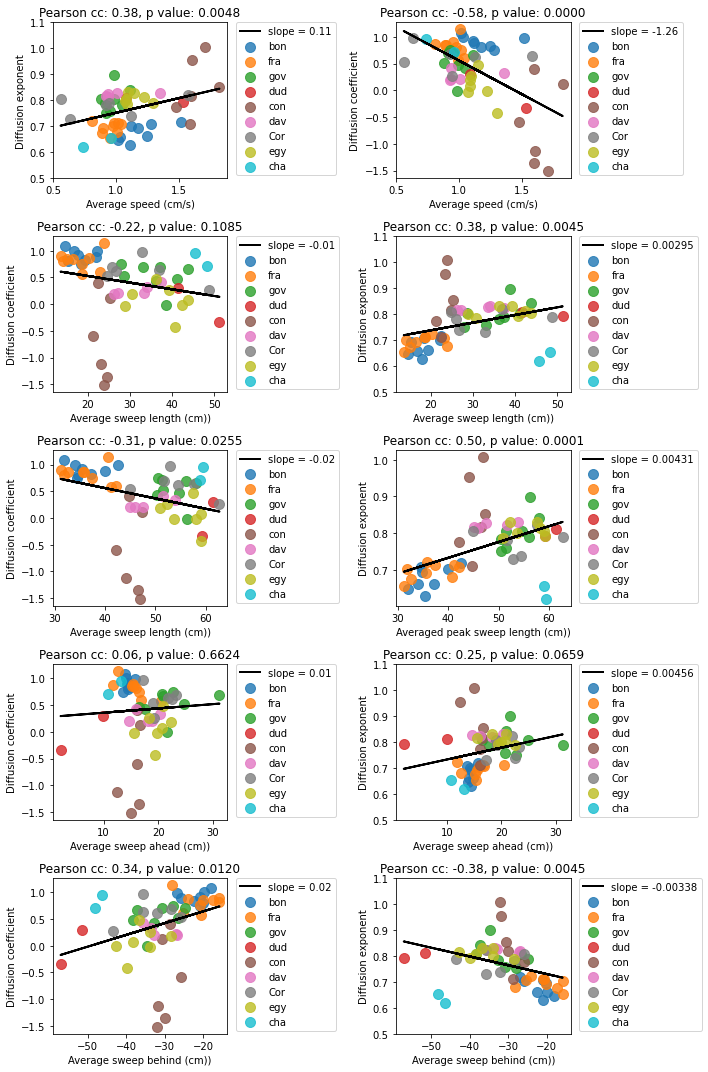

In [5]:
#first avearge all the values under each key in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday...
all_ave_speed_perday_ave = {}
all_ave_activespeed_perday_ave = {}
all_behav_exponent_perday_ave = {}
all_sweep_len_perday_ave = {}
all_sweep_amp_perday_ave = {}
all_sweep_ahead_perday_ave = {}
all_sweep_behind_perday_ave = {}
all_sweep_mass_perday_ave = {}
all_exponent_perday_ave = {}
all_intercept_perday_ave = {}
for key in all_ave_speed_perday.keys():
    all_ave_speed_perday_ave[key] = np.mean(all_ave_speed_perday[key])
    all_ave_activespeed_perday_ave[key] = np.mean(all_ave_activespeed_perday[key])
    all_behav_exponent_perday_ave[key] = np.mean(all_behav_exponent_perday[key])
    all_sweep_len_perday_ave[key] = np.mean(all_sweep_len_perday[key])
    all_sweep_amp_perday_ave[key] = np.mean(all_sweep_amp_perday[key])
    all_sweep_ahead_perday_ave[key] = np.mean(all_sweep_ahead_perday[key])
    all_sweep_behind_perday_ave[key] = np.mean(all_sweep_behind_perday[key])
    all_sweep_mass_perday_ave[key] = np.mean(all_sweep_mass_perday[key])
    all_exponent_perday_ave[key] = np.mean(all_exponent_perday[key])
    all_intercept_perday_ave[key] = np.mean(all_intercept_perday[key])
    
#group all the keys in all_ave_speed_perday, all_sweep_len_perday, all_exponent_perday by animal name
all_ave_speed_perday_concat = {}
all_ave_activespeed_perday_concat = {}
all_behav_exponent_perday_concat = {}
all_sweep_len_perday_concat = {}
all_sweep_amp_perday_concat = {}
all_sweep_ahead_perday_concat = {}
all_sweep_behind_perday_concat = {}
all_sweep_mass_perday_concat = {}
all_exponent_perday_concat = {}
all_intercept_perday_concat = {}
for key in all_ave_speed_perday.keys():
    all_ave_speed_perday_concat.setdefault(key[0], []).append(all_ave_speed_perday_ave[key])
    all_ave_activespeed_perday_concat.setdefault(key[0], []).append(all_ave_activespeed_perday_ave[key])
    all_behav_exponent_perday_concat.setdefault(key[0], []).append(all_behav_exponent_perday_ave[key])
    all_sweep_len_perday_concat.setdefault(key[0], []).append(all_sweep_len_perday_ave[key])
    all_sweep_amp_perday_concat.setdefault(key[0], []).append(all_sweep_amp_perday_ave[key])
    all_sweep_ahead_perday_concat.setdefault(key[0], []).append(all_sweep_ahead_perday_ave[key])
    all_sweep_behind_perday_concat.setdefault(key[0], []).append(all_sweep_behind_perday_ave[key])
    all_sweep_mass_perday_concat.setdefault(key[0], []).append(all_sweep_mass_perday_ave[key])
    all_exponent_perday_concat.setdefault(key[0], []).append(all_exponent_perday_ave[key])
    all_intercept_perday_concat.setdefault(key[0], []).append(all_intercept_perday_ave[key])
   
#select colors equals to number of animals from a colormap
#put them in a dictionary with animal names as keys
#delete fra from animal_names

colors = plt.cm.get_cmap('tab10', len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)
 
plt.figure(figsize=(10,15))

plt.subplot(5,2,1)
#plot all_exponent_perday_concat against all_ave_speed_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_ave_speed_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_speed_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
speed_np = np.concatenate(list(all_ave_speed_perday_concat.values()))
slope, intercept = np.polyfit(speed_np, exp_np, 1)
plt.plot(speed_np, speed_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)

#pearson test
corr, p = pearsonr(speed_np, exp_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average speed (cm/s)')
plt.ylabel('Diffusion exponent')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim([0.5, 1.1])

#intercept
plt.subplot(5,2,2)
#plot all_intercept_perday_concat against all_ave_speed_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_ave_speed_perday_concat[name]), 
                np.array(all_intercept_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_speed_perday_concat and all_intercept_perday_concat to numpy array
intercept_np = np.concatenate(list(all_intercept_perday_concat.values()))
speed_np = np.concatenate(list(all_ave_speed_perday_concat.values()))
slope, intercept = np.polyfit(speed_np, intercept_np, 1)
plt.plot(speed_np, speed_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)

#pearson test
corr, p = pearsonr(speed_np, intercept_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average speed (cm/s)')
plt.ylabel('Diffusion coefficient')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.subplot(5,2,3)
#plot all_intercept_perday_concat against all_sweep_len_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_len_perday_concat[name]), 
                np.array(all_intercept_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_intercept_perday_concat to numpy array
intercept_np = np.concatenate(list(all_intercept_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_len_perday_concat.values()))
slope, intercept = np.polyfit(sweep_len_np, intercept_np, 1)
plt.plot(sweep_len_np, sweep_len_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(sweep_len_np, intercept_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average sweep length (cm))')
plt.ylabel('Diffusion coefficient')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.subplot(5,2,4)
#plot all_exponent_perday_concat against all_sweep_len_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_len_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])   
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_len_perday_concat.values()))
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
plt.plot(sweep_len_np, sweep_len_np*slope+intercept, 'k-', label='slope = %.5f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(sweep_len_np, exp_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average sweep length (cm))')
plt.ylabel('Diffusion exponent')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim([0.5, 1.1])

plt.subplot(5,2,5)
#plot all_intercept_perday_concat against all_sweep_len_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_amp_perday_concat[name]), 
                np.array(all_intercept_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_intercept_perday_concat to numpy array
intercept_np = np.concatenate(list(all_intercept_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_amp_perday_concat.values()))
slope, intercept = np.polyfit(sweep_len_np, intercept_np, 1)
plt.plot(sweep_len_np, sweep_len_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(sweep_len_np, intercept_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average sweep length (cm))')
plt.ylabel('Diffusion coefficient')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.subplot(5,2,6)
#plot all_exponent_perday_concat against all_sweep_len_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_amp_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])   
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_amp_perday_concat.values()))
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
plt.plot(sweep_len_np, sweep_len_np*slope+intercept, 'k-', label='slope = %.5f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(sweep_len_np, exp_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Averaged peak sweep length (cm))')
plt.ylabel('Diffusion exponent')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.subplot(5,2,7)
#plot all_intercept_perday_concat against all_sweep_ahead_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_ahead_perday_concat[name]), 
                np.array(all_intercept_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_ahead_perday_concat and all_intercept_perday_concat to numpy array   
intercept_np = np.concatenate(list(all_intercept_perday_concat.values()))
sweep_ahead_np = np.concatenate(list(all_sweep_ahead_perday_concat.values()))
slope, intercept = np.polyfit(sweep_ahead_np, intercept_np, 1)
plt.plot(sweep_ahead_np, sweep_ahead_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(sweep_ahead_np, intercept_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average sweep ahead (cm))')
plt.ylabel('Diffusion coefficient')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.subplot(5,2,8)
#plot all_exponent_perday_concat against all_sweep_ahead_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_ahead_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_ahead_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
sweep_ahead_np = np.concatenate(list(all_sweep_ahead_perday_concat.values()))
slope, intercept = np.polyfit(sweep_ahead_np, exp_np, 1)
plt.plot(sweep_ahead_np, sweep_ahead_np*slope+intercept, 'k-', label='slope = %.5f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(sweep_ahead_np, exp_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average sweep ahead (cm))')
plt.ylabel('Diffusion exponent')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim([0.5, 1.1])

plt.subplot(5,2,9)
#plot all_intercept_perday_concat against all_sweep_behind_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_behind_perday_concat[name]), 
                np.array(all_intercept_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_behind_perday_concat and all_intercept_perday_concat to numpy array
intercept_np = np.concatenate(list(all_intercept_perday_concat.values()))
sweep_behind_np = np.concatenate(list(all_sweep_behind_perday_concat.values()))
slope, intercept = np.polyfit(sweep_behind_np, intercept_np, 1)
plt.plot(sweep_behind_np, sweep_behind_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(sweep_behind_np, intercept_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average sweep behind (cm))')
plt.ylabel('Diffusion coefficient')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.subplot(5,2,10)
#plot all_exponent_perday_concat against all_sweep_behind_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_behind_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_behind_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
sweep_behind_np = np.concatenate(list(all_sweep_behind_perday_concat.values()))
slope, intercept = np.polyfit(sweep_behind_np, exp_np, 1)
plt.plot(sweep_behind_np, sweep_behind_np*slope+intercept, 'k-', label='slope = %.5f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(sweep_behind_np, exp_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average sweep behind (cm))')
plt.ylabel('Diffusion exponent')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim([0.5, 1.1])


plt.tight_layout()
plt.show()

# store animal_names, all_sweep_len_perday_concat, all_exponent_perday_concat together in one pkl file 
# using pickle for producing paper figure in another script
import pickle
with open('../../Processed-Data/sweep_replay_correlation_realdata.pkl', 'wb') as f:
    pickle.dump([animal_names, all_sweep_len_perday_concat, all_sweep_amp_perday_concat, all_sweep_ahead_perday_concat, all_sweep_behind_perday_concat, all_exponent_perday_concat, all_ave_activespeed_perday_concat], f)

with open('../../Processed-Data/sweep_replay_correlation_realdata_persession.pkl', 'wb') as f:
    pickle.dump([animal_names, all_sweep_len_peranimal, all_sweep_amp_peranimal, all_sweep_ahead_peranimal, all_sweep_behind_peranimal, all_exponent_peranimal, all_ave_activespeed_peranimal], f)



### check the correlation with active speed

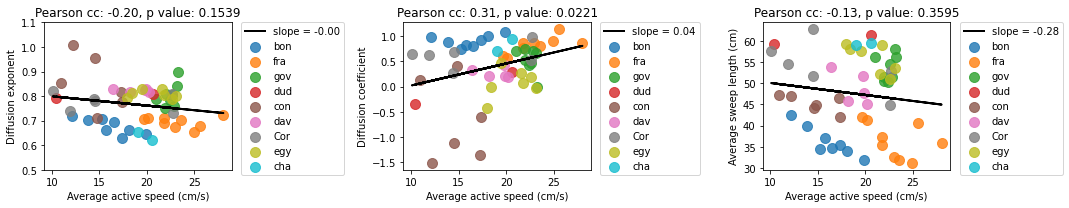

In [59]:
#plot the exponent against average active speed, and intercept against average active speed
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
#plot all_exponent_perday_concat against all_ave_activespeed_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_ave_activespeed_perday_concat[name]), 
                np.array(all_exponent_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_activespeed_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
speed_np = np.concatenate(list(all_ave_activespeed_perday_concat.values()))
slope, intercept = np.polyfit(speed_np, exp_np, 1)
plt.plot(speed_np, speed_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(speed_np, exp_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average active speed (cm/s)')
plt.ylabel('Diffusion exponent')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim([0.5, 1.1])

#intercept
plt.subplot(1,3,2)
#plot all_intercept_perday_concat against all_ave_activespeed_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_ave_activespeed_perday_concat[name]), 
                np.array(all_intercept_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_activespeed_perday_concat and all_intercept_perday_concat to numpy array
intercept_np = np.concatenate(list(all_intercept_perday_concat.values()))
speed_np = np.concatenate(list(all_ave_activespeed_perday_concat.values()))
slope, intercept = np.polyfit(speed_np, intercept_np, 1)
plt.plot(speed_np, speed_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(speed_np, intercept_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average active speed (cm/s)')
plt.ylabel('Diffusion coefficient')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#plot sweep length against average active speed
plt.subplot(1,3,3)
#plot all_sweep_amp_perday_concat against all_ave_activespeed_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_ave_activespeed_perday_concat[name]), 
                np.array(all_sweep_amp_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_ave_activespeed_perday_concat and all_sweep_amp_perday_concat to numpy array
sweep_len_np = np.concatenate(list(all_sweep_amp_perday_concat.values()))
speed_np = np.concatenate(list(all_ave_activespeed_perday_concat.values()))
slope, intercept = np.polyfit(speed_np, sweep_len_np, 1)
plt.plot(speed_np, speed_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)
#pearson test
corr, p = pearsonr(speed_np, sweep_len_np)
plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average active speed (cm/s)')
plt.ylabel('Average sweep length (cm)')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    

plt.tight_layout()
plt.show()


### check the delay compensation

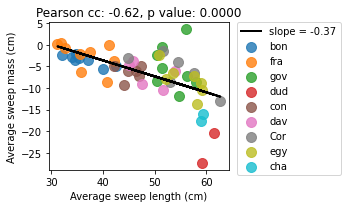

In [12]:
#check the correlation between all_sweep_mass_perday_concat and all_swep_len_perday_concat
plt.figure(figsize=(5,3))
#plot all_sweep_mass_perday_concat against all_sweep_len_perday_concat
for name in animal_names:
    plt.scatter(np.array(all_sweep_amp_perday_concat[name]), 
                np.array(all_sweep_mass_perday_concat[name]), 
                label=name, s=100, alpha=0.8, color=color_dict[name])
#add linear fit line to the plot using numpy.polyfit
#convert all_sweep_len_perday_concat and all_sweep_mass_perday_concat to numpy array
sweep_len_np = np.concatenate(list(all_sweep_amp_perday_concat.values()))
sweep_mass_np = np.concatenate(list(all_sweep_mass_perday_concat.values()))
slope, intercept = np.polyfit(sweep_len_np, sweep_mass_np, 1)
plt.plot(sweep_len_np, sweep_len_np*slope+intercept, 'k-', label='slope = %.2f'%slope, linewidth=2)

#pearson test
corr, p = pearsonr(sweep_len_np, sweep_mass_np)

plt.title('Pearson cc: %.2f, p value: %.4f'%(corr, p))
plt.xlabel('Average sweep length (cm)')
plt.ylabel('Average sweep mass (cm)')
#put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()

### check the experience effect on theat sweep length and replay diffusivity. across epochs

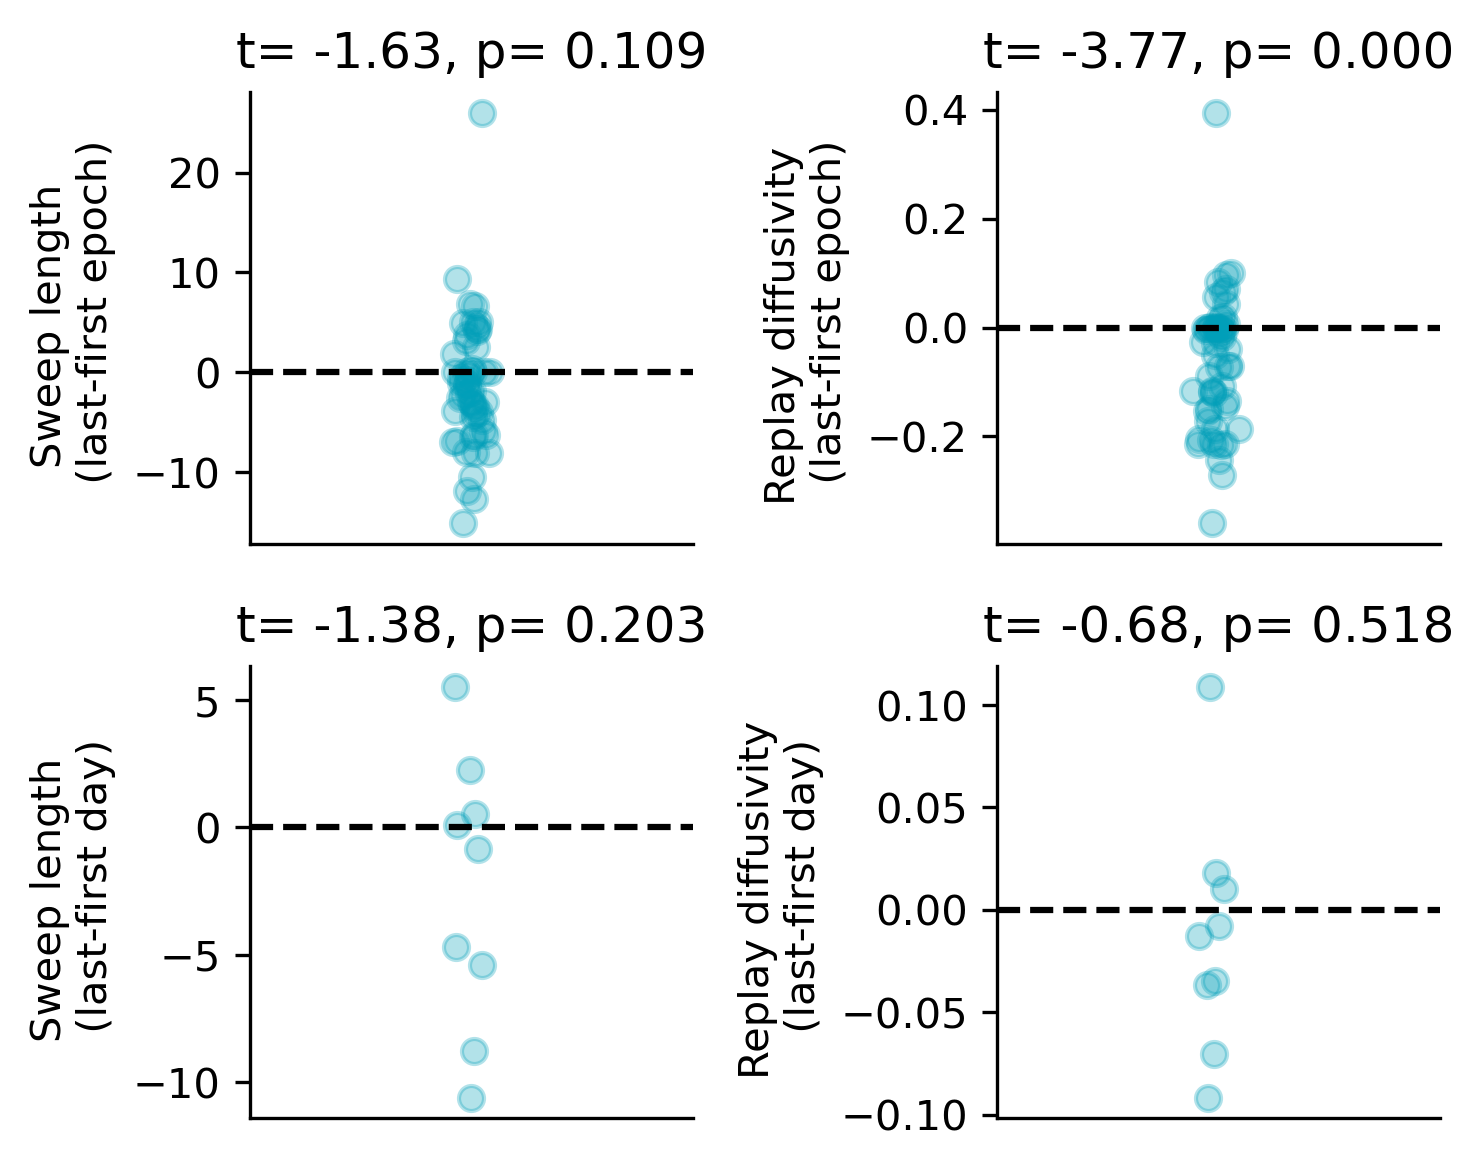

In [58]:
fig, axs = plt.subplots(2, 2, figsize=(5, 4), dpi=300)

ax0 = axs[0,0]
Diff = []
for key, value in all_sweep_amp_perday.items():
    #get the differnce between the first elemnt and the last element in value
    diff = value[-1] - value[0]
    Diff.append(diff)
#do a scatter plot and one sample t test
ax0.scatter(np.ones(len(Diff))+np.random.normal(0, 0.02, len(Diff)), Diff, color = '#009FB9', alpha=0.3)
ax0.set_xlim([0.5, 1.5])
#add a horizontal line at y=0
ax0.axhline(y=0, color='k', linestyle='--')

#one sample t test, return t value and p value
from scipy.stats import ttest_1samp
t, p = ttest_1samp(Diff, 0)
#add t and p value to the plot as text
ax0.set_title('t= %.2f, p= %.3f'%(t, p))
#remove xticks
ax0.set_xticks([])
ax0.set_ylabel('Sweep length \n (last-first epoch)')
#right and top spines are not visible
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)



ax1 = axs[0,1]
Diff = []
for key, value in all_exponent_perday.items():
    #get the differnce between the first elemnt and the last element in value
    diff = value[-1] - value[0]
    Diff.append(diff)
#do a scatter plot and one sample t test
ax1.scatter(np.ones(len(Diff))+np.random.normal(0, 0.02, len(Diff)), Diff, color = '#009FB9', alpha=0.3)
#xlim([0.5, 1.5]
ax1.set_xlim([0.5, 1.5])
#add y=0 horizontal line
ax1.axhline(y=0, color='k', linestyle='--')

#one sample t test, return t value and p value
t, p = ttest_1samp(Diff, 0)
ax1.set_title('t= %.2f, p= %.3f'%(t, p))
#remove xticks
ax1.set_xticks([])
ax1.set_ylabel('Replay diffusivity \n (last-first epoch)')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2 = axs[1,0]
Diff = []
for key, value in all_sweep_amp_perday_concat.items():
    #get the differnce between the first elemnt and the last element in value
    diff = value[-1] - value[0]
    Diff.append(diff)
#do a scatter plot and one sample t test
ax2.scatter(np.ones(len(Diff))+np.random.normal(0, 0.02, len(Diff)), Diff, color = '#009FB9', alpha=0.3)
#xlim([0.5, 1.5]
ax2.set_xlim([0.5, 1.5])
#add y=0 horizontal line
ax2.axhline(y=0, color='k', linestyle='--')

#one sample t test, return t value and p value
t, p = ttest_1samp(Diff, 0)
ax2.set_title('t= %.2f, p= %.3f'%(t, p))
#remove xticks
ax2.set_xticks([])
ax2.set_ylabel('Sweep length \n (last-first day)')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax3 = axs[1,1]
Diff = []
for key, value in all_exponent_perday_concat.items():
    #get the differnce between the first elemnt and the last element in value
    diff = value[-1] - value[0]
    Diff.append(diff)
#do a scatter plot and one sample t test
ax3.scatter(np.ones(len(Diff))+np.random.normal(0, 0.02, len(Diff)), Diff, color = '#009FB9', alpha=0.3)
#xlim([0.5, 1.5]
ax3.set_xlim([0.5, 1.5])
#add y=0 horizontal line
ax3.axhline(y=0, color='k', linestyle='--')

#one sample t test, return t value and p value
t, p = ttest_1samp(Diff, 0)
ax3.set_title('t= %.2f, p= %.3f'%(t, p))
#remove xticks
ax3.set_xticks([])
ax3.set_ylabel('Replay diffusivity \n (last-first day)')
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

plt.tight_layout()